In [1]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(sankeyD3))
suppressPackageStartupMessages(library(htmlwidgets))
suppressPackageStartupMessages(library(webshot))
suppressPackageStartupMessages(library(ggplot2))
source("auc.fun.R")


inputdir <- "./load_files/"
outputdir <- "./report/"

seu <- readRDS(file = paste0("../overview/load_files/", "PAT_inte.organizer.inte.rds"))


Attaching package: ‘AUCell’


The following object is masked from ‘package:base’:

    cbind




In [2]:
## Get mouse markers for computing the similarity
MarFile <- "./load_files/PAT_RhesusMouse_MarkerAVGs_forSankey.Rdata"

if (!file.exists(MarFile)){
    load(file = paste0(inputdir, "PAT_RhesusMouse_data.Rdata")) 
    ## rpat, mpat. Prepared in the script macaque.mouse.compare.ipynb


    ## Mouse markers & AVGs
    Idents(mpat) <- "subclass"
    mou_res <- FindAllMarkers(mpat, logfc.threshold = 0.2, min.pct = 0.1)
    mou_avgs <- log(AverageExpression(mpat, assay = "RNA")$RNA + 1)


    ## Rhesus markers & AVGs
    Idents(seu) <- "subtype"
    rhe_avgs <- log(AverageExpression(seu)$RNA + 1) ## use seu, not rpat (seu has more complete organizer subtypes)

    sel_cls <- c("PC FGF17", "PC NKX2-1 LMO1", "PC NKX2-1 NKX6-2", "PC SFRP1", 
                 "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2", "GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1")
    rhe_res <- lapply(sel_cls, function(x) {
            mm <- FindMarkers(seu, ident.1 = x, logfc.threshold = 0.1, min.pct = 0.05, only.pos = TRUE) %>%
                    tibble::rownames_to_column("gene") %>%
                    mutate(cluster = x) %>%
                    mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01))
            mm
            }) %>% 
                    do.call(rbind, .)
    save(mou_res, mou_avgs, rhe_res, rhe_avgs, file = MarFile)
}
load(MarFile) ## mou_res, mou_avgs, rhe_res, rhe_avgs

In [3]:
##------------------------------------------------------------------------
## Get markers for sankey plot

## Extract markers
extract_mars <- function(res, fc = 1.2) {
    mm <- res %>%
        mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01)) %>%
        filter(ratio_fc >= fc) %>%
        group_by(cluster) %>%
        mutate(p_val_adj = p.adjust(p_val, method = "fdr")) %>%
        filter(p_val_adj <= 0.01) %>%
        ungroup() %>%
        group_by(cluster) %>%
        top_n(150, wt = avg_logFC)
    nn <- split(mm$gene, mm$cluster)
    nn
}


rhe_mars <- extract_mars(res = rhe_res, fc = 1.25) %>% unlist() %>% unique()
mou_mars <- extract_mars(res = mou_res, fc = 1.25) %>% unlist() %>% unique()
sh_mars <- intersect(rhe_mars, toupper(mou_mars)) %>%
                intersect(., rownames(rhe_avgs)) %>%
                intersect(., rownames(mou_avgs))


rord <- c("PC FGF17", "PC NKX2-1 LMO1", "PC NKX2-1 NKX6-2",
          "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")## "PC SFRP1", "GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1")
mord <- c("Anteromedial cerebral pole", "Hypothalamic floor-plate like", 
          "Cortical hem 1", "Cortical hem 2", "Antihem 1", "Antihem 2", "Zona limitans intrathalamica")
sh_mars

[1] "MEIS2"     "SFRP1"     "FAM181B"   "TSPAN7"    "STMN2"     "LMO1"     
  [7] "ESRRG"     "GAP43"     "STMN4"     "FSTL5"     "DLK1"      "PBX3"     
 [13] "MBIP"      "DDAH1"     "PCLAF"     "NKX2-1"    "FEZ1"      "FGFBP3"   
 [19] "HMGCS1"    "NUSAP1"    "MKI67"     "NCAM1"     "SLC1A3"    "HIST1H1B" 
 [25] "PTTG1"     "CXXC4"     "CENPF"     "NKX6-2"    "CDCA3"     "LDB2"     
 [31] "PTPRN2"    "PTBP2"     "SHTN1"     "CREB5"     "GNAO1"     "FAM171B"  
 [37] "ZFHX3"     "ADGRB3"    "BIRC5"     "EFNB1"     "KIF22"     "ASPM"     
 [43] "TCF7L2"    "TK1"       "GMNN"      "DKK3"      "PBK"       "RTN1"     
 [49] "KIF21A"    "CDCA8"     "PTCH1"     "EFNA5"     "RBP1"      "DLX2"     
 [55] "HES5"      "GSX2"      "LIMCH1"    "RORB"      "ZEB2"      "BCAN"     
 [61] "IGDCC3"    "NKAIN3"    "UHRF1"     "SOX6"      "MAP2"      "NOTCH1"   
 [67] "NPAS3"     "TOX3"      "LSAMP"     "NEDD4L"    "DCLK1"     "SETBP1"   
 [73] "EPHB2"     "BCL11A"    "EDNRB"     "PLPP3"     "HEY1"      "FGF17"    
 [79] "ZIC4"      "FGF8"      "SPRY1"     "CLYBL"     "DUSP6"     "IL17RD"   
 [85] "SMOC1"     "NPM3"      "NFIA"      "TMEM132D"  "ZIC1"      "FABP7"    
 [91] "ZIC3"      "CDKN1C"    "CCND1"     "SIX3"      "ATP1A2"    "FEZF2"    
 [97] "GAS1"      "CSRNP3"    "GALNT12"   "MFAP2"     "ARL4C"     "RSPO1"    
[103] "OTX2"      "TGIF1"     "IGFBP5"    "SELENOP"   "CALD1"     "TLE4"     
[109] "TENM3"     "NFIB"      "PPP1R1A"   "NR2F6"     "FEZF1"     "SLIT2"    
[115] "RAB34"     "SPARCL1"   "SHH"       "COL9A3"    "GPC3"      "SPON1"    
[121] "PRC1"      "PSRC1"     "AURKA"     "PIMREG"    "UBE2C"     "KNSTRN"   
[127] "CDC25C"    "HMMR"      "PLK1"      "CCNA2"     "CENPE"     "CKAP2"    
[133] "TCF7L1"    "TACC3"     "KIFC1"     "CDKN3"     "FST"       "SGCE"     
[139] "LMO2"      "TOX2"      "SLC2A1"    "NRCAM"     "PCSK1N"    "EPHB1"    
[145] "NR2F2"     "SYT1"      "MEIS3"     "PLAGL1"    "TXNIP"     "GAS6"     
[151] "PLXDC2"    "BMP7"      "METRN"     "COTL1"     "MCM7"      "MCM3"     
[157] "CDT1"      "RSPO3"     "EMX2"      "WLS"       "CENPW"     "RSPO2"    
[163] "TPBG"      "DACH1"     "ID3"       "DMRTA2"    "WNT8B"     "MASP1"    
[169] "CACHD1"    "FLRT3"     "SP5"       "PRTG"      "RAB11FIP2" "EMX1"     
[175] "SULF2"     "NR2F1"     "DMRT3"     "RFX4"      "AXIN2"     "PEG3"     
[181] "LY6H"      "CNTNAP2"   "NEUROG2"   "EMC2"      "ID1"       "RGCC"     
[187] "HPCAL1"    "EHBP1"     "LEF1"      "WNT7B"     "BASP1"     "SPINT2"   
[193] "LRRN1"     "IER2"      "PLEKHG1"   "CDH11"     "FAT3"      "NREP"     
[199] "TMEM47"    "ADGRG1"    "CELF2"     "HMGA1"     "PCNA"      "TYMS"     
[205] "SMS"       "RRM2"      "BCAT1"     "RFC3"      "STMN3"     "CYTL1"    
[211] "LIG1"      "S100A10"   "COL4A2"    "B2M"       "PRDM16"    "NOP56"    
[217] "FEN1"      "FOS"       "UNG"       "PAX6"      "VCAM1"     "ARL4A"    
[223] "PTPRZ1"    "PTX3"      "RGS20"     "CLU"       "ARID5B"    "FAM181A"  
[229] "LMAN1"     "ID4"       "GPM6B"     "HIST1H1E"  "VEPH1"     "TLE1"     
[235] "LTBP1"     "CADM2"     "GNG2"      "TAGLN3"    "ATAD2"     "BARHL2"   
[241] "IGFBPL1"   "NTNG1"     "FOXB1"     "OTX1"      "CSPG5"     "CITED2"   
[247] "BZW2"      "FABP5"     "APRT"      "SPATS2L"   "ARL6IP4"   "PCBD1"    
[253] "CEP112"    "POLR3K"    "TTR"       "CLIC6"     "CRABP1"    "CFAP126"  
[259] "FOXJ1"     "KCNJ13"    "ENO3"      "COLEC12"   "SULF1"     "VAT1L"    
[265] "DKK2"      "HTR2C"     "RBM47"     "SOSTDC1"   "PPP2R2B"   "SLC16A10" 
[271] "MAF"       "MSX1"      "PDZRN3"    "TRPM3"     "ID2"       "GJA1"     
[277] "NTM"       "MECOM"     "KLHDC8B"   "CHCHD10"   "SLC22A17"  "PDLIM7"

In [4]:
## Construct the sankey plot
simi <- cor(rhe_avgs[sh_mars, rord], mou_avgs[sh_mars, mord])
simi <- apply(simi, 1, function(x) {
            x[x < quantile(x, 0.8)] <- NA
            x
            }) %>% t()
links <- simi %>%
            reshape2::melt() %>%
            setNames(., c("from", "to", "weight")) %>%
            filter(!is.na(weight)) %>%
            group_by(from) %>%
            top_n(., 2, wt = weight)

meta <- data.frame(cluster = c(rord, mord), 
            label = c(gsub("_", " ", rord), mord),
            stringsAsFactors = FALSE)
links$IDsource=match(links$from, meta$cluster)-1 
links$IDtarget=match(links$to, meta$cluster)-1

gps <- paste(meta$cluster, collapse = '", "') %>%
  paste0('"', ., '"')
gg_color_hue <- function(n) {
    hues = seq(15, 375, length = n + 1)
    hcl(h = hues, l = 65, c = 100)[1:n]
}

colors <- paste(gg_color_hue(nrow(meta)), collapse = '", "') %>%
  paste0('"', ., '"')
my_color <- paste0('d3.scaleOrdinal() .domain([', gps, ']) .range([', colors, '])')

p <- sankeyNetwork(Links = links, Nodes = meta,
                   Source = "IDsource", Target = "IDtarget",
                   Value = "weight", NodeID = "label", colourScale = my_color, 
                   showNodeValues = FALSE, 
                   iterations = 0, nodeWidth = 20, nodeStrokeWidth = 1, nodePadding = 10)
p

##saveWidget(p, file="./PAT_RM_sankey.html")
##webshot("./PAT_RM_sankey.html", "./PAT_RM_sankey.pdf", delay = 0.2, vwidth = 400)

Links is a tbl_df. Converting to a plain data frame.



HTML widgets cannot be represented in plain text (need html)

In [5]:
## Calculate AUC scores measuring the enrichment of mouse markers in macaque subtypes
mou_mars <- extract_mars(res = mou_res, fc = 1.5) %>%
            lapply(., function(x) intersect(x, rownames(seu)))
mord <- c("Anteromedial cerebral pole", "Hypothalamic floor-plate like", 
          "Cortical hem 1", "Cortical hem 2", "Antihem 1", "Antihem 2", "Zona limitans intrathalamica")


## Get the AUROC scores 
all_auc <- GetModuleScore(assay.data = seu$RNA@data, 
                          features = mou_mars, method = "aucell", 
                          file_name = "PAT_match_mouse_AUC", input_dir = inputdir)$auc
seu[["auc"]] <- CreateAssayObject(data = t(all_auc))

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(mord)` instead of `mord` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



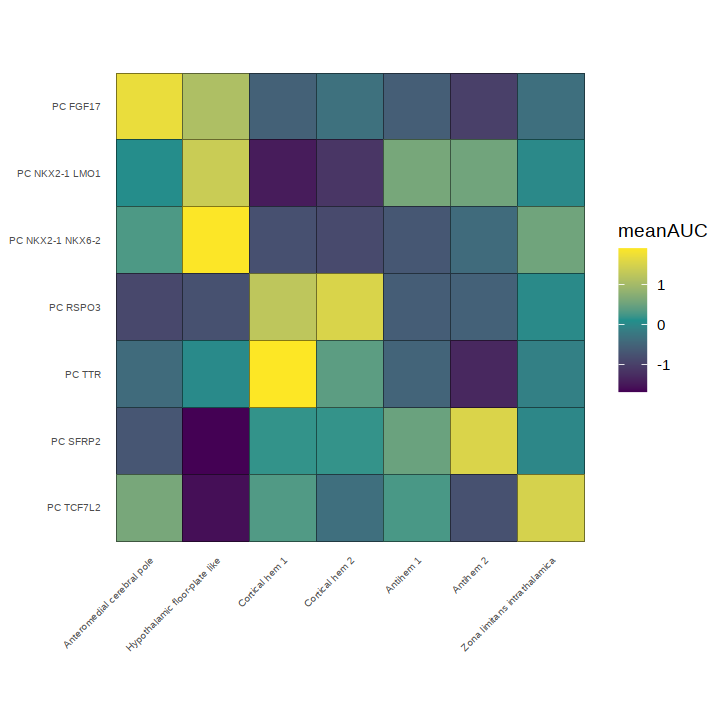

In [6]:
## Plot average AUC scores                 
scval <- function(x) {(x - mean(x))/sd(x)}
pdata <- seu$auc@data %>%
            t() %>% scale() %>%
            MinMax(., min = -2, max = 2) %>%
            as.data.frame(., check.names = FALSE) %>%
            aggregate(., by = list(subtype = seu@meta.data$subtype), mean) %>%
            filter(subtype %in% c("PC FGF17", "PC NKX2-1 LMO1", "PC NKX2-1 NKX6-2", 
                                  "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")) %>%
            tidyr::gather(., "celltype", "meanAUC", mord) %>%
            group_by(subtype) %>%
            mutate(meanAUC = scval(meanAUC)) %>%
            mutate(subtype = factor(subtype, levels = rev(c("PC FGF17", "PC NKX2-1 LMO1", "PC NKX2-1 NKX6-2", 
                                                            "PC SFRP1", "PC RSPO3", "PC TTR", 
                                                            "PC SFRP2", "PC TCF7L2")))) %>%
            mutate(celltype = factor(celltype, levels = mord))

p <- ggplot(pdata, aes_string(x = "celltype", y = "subtype", fill = "meanAUC")) +
                geom_tile(width = 1, height = 1, size = 0.1, color = "black") +
                scale_fill_gradientn(colors = viridis::viridis(3)) +
                theme_classic() +
                RotatedAxis() + 
                coord_fixed() +
                theme(legend.position = "right", 
                      axis.text = element_text(size = rel(0.5)), 
                      axis.line = element_blank(), 
                      axis.ticks = element_blank(), 
                      axis.title = element_blank())
options(repr.plot.width=6, repr.plot.height=6, res = 300)
p

In [7]:
pdf(paste0(outputdir, "PAT_match_mouse_averageAUC_heatmap.pdf"), width = 6, height = 6)
print(p)
dev.off()

png 
  2

In [8]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] AUCell_1.8.0         ggplot2_3.3.0        webshot_0.5.2       
[4] htmlwidgets_1.5.1    sankeyD3_0.3.2       circlize_0.4.13     
[7] ComplexHeatmap_2.2.0 dplyr_1.0.7       